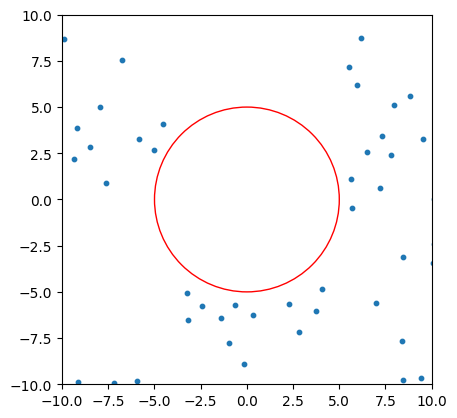

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Constants
NUM_PARTICLES = 500
TIME_STEP = 0.1
PARTICLE_RADIUS = 0.5
CIRCLE_CENTER = np.array([0, 0])
CIRCLE_RADIUS = 5
FRAME_COUNT = 200

# Initialize particles
particles = {
    'position': np.random.rand(NUM_PARTICLES, 2) * 20 - 10,
    'velocity': np.random.randn(NUM_PARTICLES, 2)
}

def update_particles(particles):
    # Update particle positions
    particles['position'] += particles['velocity'] * TIME_STEP

    # Particle-to-particle collision
    for i in range(NUM_PARTICLES):
        for j in range(i + 1, NUM_PARTICLES):
            dist = np.linalg.norm(particles['position'][i] - particles['position'][j])
            if dist < 2 * PARTICLE_RADIUS:
                # Calculate collision response
                direction = (particles['position'][i] - particles['position'][j]) / dist
                v1 = particles['velocity'][i]
                v2 = particles['velocity'][j]
                particles['velocity'][i] = v1 - np.dot(v1 - v2, direction) * direction
                particles['velocity'][j] = v2 + np.dot(v1 - v2, direction) * direction

                # Separate overlapping particles
                overlap = 2 * PARTICLE_RADIUS - dist
                particles['position'][i] += direction * overlap / 2
                particles['position'][j] -= direction * overlap / 2

    # Particle-to-circle collision
    for i in range(NUM_PARTICLES):
        dist_to_center = np.linalg.norm(particles['position'][i] - CIRCLE_CENTER)
        if dist_to_center < CIRCLE_RADIUS + PARTICLE_RADIUS:
            # Reflect velocity
            direction = (particles['position'][i] - CIRCLE_CENTER) / dist_to_center
            particles['velocity'][i] -= 2 * np.dot(particles['velocity'][i], direction) * direction
            # Reposition particle outside the circle to prevent overlap
            overlap = CIRCLE_RADIUS + PARTICLE_RADIUS - dist_to_center
            particles['position'][i] += direction * overlap

def animate(frame):
    update_particles(particles)
    plt.cla()
    circle = plt.Circle(CIRCLE_CENTER, CIRCLE_RADIUS, color='r', fill=False)
    plt.gca().add_patch(circle)
    plt.scatter(particles['position'][:, 0], particles['position'][:, 1], s=10)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.gca().set_aspect('equal', adjustable='box')

# Create animation
fig = plt.figure()
ani = FuncAnimation(fig, animate, frames=FRAME_COUNT, interval=100)

# Save the animation as a GIF
ani.save('particle_animation.gif', writer=PillowWriter(fps=20))
